### Barlow Twins
* **BarlowTwins** objective function that naturally avoids collapse by measuring the cross-correlation matrix between the outputs of two identical networks fed with distorted versions of a sample, and making it as close to the identity matrix as possible. This causes the embedding vectors of distorted versions of a sample to be similar, while minimizing the redundancy between the components of these vectors. The method is called BARLOW TWINS.
* This is name coming from neuroscientist H. Barlow’s redundancy-reduction principle applied to a pair of identical networks.
* This Paper is published by Collobrative with YanLeCun Facebook Team.

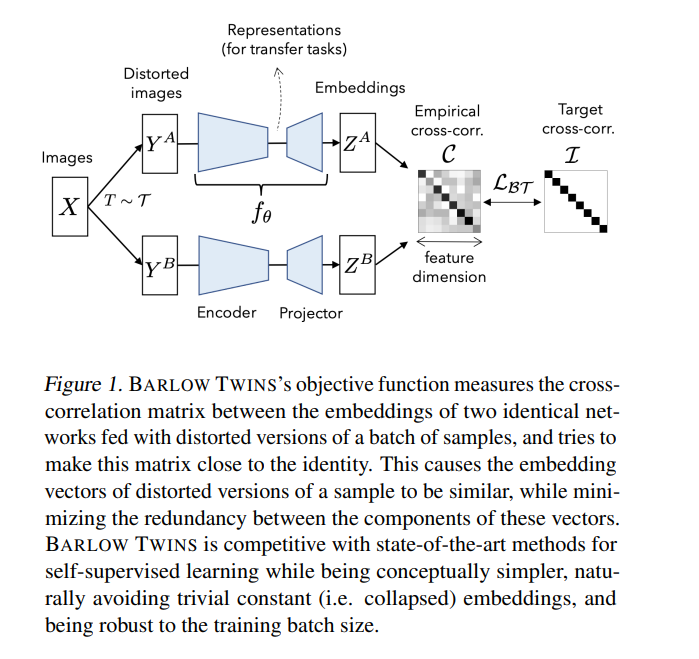

In [1]:
# !pip install lightly av

In [46]:
import torch
from torch import nn
import torchvision

from lightly.data import LightlyDataset
from lightly.data import ImageCollateFunction
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss

In [47]:
class BarlowTwins(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

In [48]:
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BarlowTwins(backbone)

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BarlowTwins(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [50]:
cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)

Files already downloaded and verified


In [51]:
collate_fn = ImageCollateFunction(input_size=32)

In [52]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1024,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [53]:
criterion = BarlowTwinsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

In [ ]:
print("Starting Training")
for epoch in range(5):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model(x0)
        z1 = model(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Starting Training


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 00, loss: 1798.96326
epoch: 01, loss: 1755.15564


KeyboardInterrupt: ignored